In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn import metrics

## Funções de treino e predição

In [2]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

In [3]:
def predict_module(model, test_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

### Função que grafica as funções de perda(custo) do treino e da validação

In [4]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

### Matriz de Confusão

In [5]:
def matriz_confusao(true_labels, predicted, display_labels=[0,1,2]):
    matriz = metrics.confusion_matrix(true_labels, predicted)
    tot = np.sum(matriz, axis=1, keepdims=True)
    np.set_printoptions(precision=2)
    m_porc = matriz/tot
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=display_labels)
    disp.plot(values_format='.2f', xticks_rotation='vertical')
    plt.show()

# Dataset 1

### Treinamento a partir de uma base propria de imagens - Intel Image Classification
<p>
Context: This is image data of Natural Scenes around the world.
</p>

<p>
<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*Y1y83HN7oI98EJT3LQgv-g.png" alt="Drawing"  width="500"/>

Content: This Data contains around 25k images of size 150x150 distributed under 6 categories.
  <ul>
    <li>buildings</li>
    <li>forest</li>
    <li>glacier</li>
    <li>mountain</li>
    <li>sea</li>
    <li>street</li>
  </ul>
</p>

<p>
Fonte: <a href="https://www.kaggle.com/datasets/puneet6060/intel-image-classification">Intel Image Classification</a>
</p>


### Usar Gdown para realizar a descarga de um arquivo desde o drive

In [6]:
# instalação da biblioteca gdown
!pip install gdown

In [7]:
# importando a biblioteca
import gdown

### Cómo utilizar?
<img src="https://drive.google.com/uc?id=1VgEEHaw-5798fIY03iWIYOIYK4-kkiNW" alt="Drawing"  width="900"/>

```
gdown --id <put-the-ID>
```

In [8]:
# Realizando a descarga do Intel Dataset usando o id do gdrive do arquivo
!gdown --id 16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft
From (redirected): https://drive.google.com/uc?id=16oJl8kDIBMvKdeAkCqXrmZCQMi9lb8ft&confirm=t&uuid=356eeefb-b62b-4b9c-882f-1428e9310b3b
To: /content/dataset.zip
100% 253M/253M [00:04<00:00, 50.7MB/s]


In [9]:
# biblioteca para descomprimir o arquivo zip
import zipfile
import os

In [10]:
# funçao que realiza a descompressão do arquivo
def unzip_dataset(filename, directory):
  """
  filename: nome do arquivo, incluir o endereço onde está localizado o arquivo
  directory: pasta onde será decomprimido o arquivo
  """
  zip_ref = zipfile.ZipFile(filename, 'r')
  zip_ref.extractall(directory)
  zip_ref.close()

### Descomprimir arquivo zip

In [11]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/content/data/Intel/'
unzip_dataset(filename='/content/dataset.zip', directory=data_dir )

In [12]:
%ls /content/data/Intel/
%ls /content/data/Intel/test

test/  train/
buildings/  forest/  glacier/  mountain/  sea/  street/


### Transformações geométricas nas imagens

In [13]:
# esse é o tamanho da imagem de entrada da CNN treinada que vamos usar
input_size = 224
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(input_size,input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Classe Dataset usando ImageFolder

In [14]:
print("Incializando Datasets ...")

# Criar conjuntos de dados de treinamento e validação
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

# image_datasets é um dicionario com as chaves 'train' e 'test'
print(image_datasets)

Incializando Datasets ...
{'train': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /content/data/Intel/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /content/data/Intel/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}


### Particionar o conjunto de treino em treino e validacão

In [15]:
# conjunto de treino é divido em treino (80%) e validação (20%)
train_dataset_split, val_dataset_split =  torch.utils.data.random_split(image_datasets['train'], [0.8, 0.2])

# é adicionado no dicionario image_datasets o conjunto de validação e o conjunto de treino é atualizado
image_datasets['val'] = train_dataset_split
image_datasets['train'] = val_dataset_split

### Definição dos Dataloaders

In [16]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Criar dataloaders de treinamento e validação
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Fine-tuning

### Função que congela ou descongela as camadas de uma rede

<p> Por *default* são carregadas descongeladas, ou seja, permite que todos os pesos da rede sejam atualizados durante o treino.</p>

In [17]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Definição da redes

### Rede MLP (Multi Layer Perceptron)

In [18]:
def make_layers(cfg, in_channels = 3):
    layers = []
    for v in cfg:
        layers += [nn.Linear(in_channels, v), nn.ReLU()]
        in_channels = v
    return nn.Sequential(*layers)

In [19]:
class MeuMLP(nn.Module):
    def __init__(self,entrada=4,camadas_escondidas=256 ,saida=3):
        super(MeuMLP, self).__init__()
        self.hidden_layers_num = camadas_escondidas
        self.dense_hidden = make_layers(self.hidden_layers_num, entrada)
        self.fc = nn.Linear(self.hidden_layers_num[-1], saida)

    def forward(self, x):
        x = self.dense_hidden(x)
        x = self.fc(x)
        return x

### Rede que implementa o Fine-tuning

In [20]:
class FineTuningNetwork(nn.Module):
    def __init__(self, backbone, classifier):
        super(FineTuningNetwork, self).__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x):
        # Passa os dados pelo backbone (CNN pré-treinada)
        features = self.backbone(x)

        # Passa as características extraídas pelo classificador (MLP)
        out = self.classifier(features)
        return out

### Finetuning com a rede VGG11

### Questão 1: Fine tuning, congelando as camadas

In [21]:
# Carrega a CNN VGG11 e os pesos treinados com a base Imagenet
backbone = models.vgg11(weights='VGG11_Weights.DEFAULT')
print(backbone)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:07<00:00, 74.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [22]:
# Remover a última camada totalmente conectada (classifier)
backbone = nn.Sequential(*list(backbone.children())[:-1])

# Adicionar uma camada de flatten (conversão para vetor)
backbone.add_module("flatten", nn.Flatten())

# Criar as camadas para classificação
classificador = MeuMLP(entrada=25088, camadas_escondidas=[256, 128, 64, 32] , saida=6 )

In [23]:
# instanciar a rede passando o backbone (nossa VGG16) e o classifier
model = FineTuningNetwork(backbone=backbone, classifier=classificador)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Congelar as camadas do backbone para não treinar novamente
set_parameter_requires_grad(backbone, feature_extracting=True)

Epoch 1/5 Train Loss: 0.6306 Test Loss: 0.4872757080953006 Duracao: 0:00:57.024894
Epoch 2/5 Train Loss: 0.4490 Test Loss: 0.44448275706648527 Duracao: 0:00:58.515903
Epoch 3/5 Train Loss: 0.3730 Test Loss: 0.40072625295121084 Duracao: 0:00:57.134850
Epoch 4/5 Train Loss: 0.3697 Test Loss: 0.41228960483385374 Duracao: 0:00:57.830847
Epoch 5/5 Train Loss: 0.3504 Test Loss: 0.40354307401962475 Duracao: 0:00:57.338687


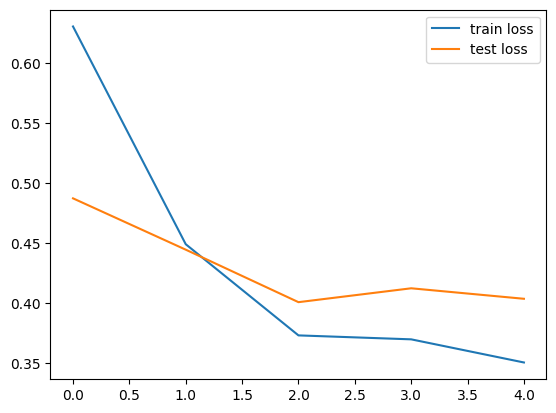

In [24]:
# verificar disponibilidade de placa de vídeo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# treinar
train_losses, test_losses = fit(model, criterion, optimizer, dataloaders_dict['train'], dataloaders_dict['val'], epochs=5)
plot_losses(train_losses, test_losses)

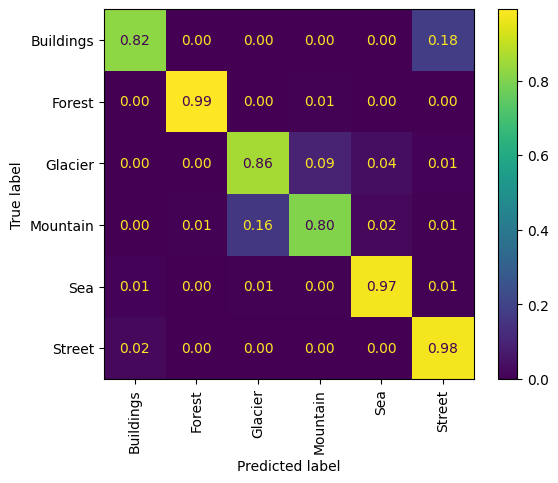

In [25]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model, dataloaders_dict['test'])
matriz_confusao(true_labels, predicted, ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'])

## Questão 2: Finetuning sem congelar camadas

In [26]:
# Carrega a CNN VGG11 e os pesos treinados com a base Imagenet
backbone2 = models.vgg11(weights='VGG11_Weights.DEFAULT')

# Remover a última camada totalmente conectada (classifier)
backbone2 = nn.Sequential(*list(backbone2.children())[:-1])

# Adicionar uma camada de flatten (conversão para vetor)
backbone2.add_module("flatten", nn.Flatten())

# Criar as camadas para classificação
classificador2 = MeuMLP(entrada=25088, camadas_escondidas=[256, 128, 64, 32] , saida=6 )

In [27]:
# instanciar a rede passando o backbone (nossa VGG16) e o classifier
model2 = FineTuningNetwork(backbone=backbone2, classifier=classificador2)

# loss and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters())


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 Train Loss: 1.6291 Test Loss: 1.4617049276107057 Duracao: 0:01:11.911518
Epoch 2/10 Train Loss: 1.3019 Test Loss: 1.1951002723131425 Duracao: 0:01:11.829911
Epoch 3/10 Train Loss: 1.1455 Test Loss: 1.203126384109853 Duracao: 0:01:12.212828
Epoch 4/10 Train Loss: 1.1244 Test Loss: 1.0132151203829678 Duracao: 0:01:12.041015
Epoch 5/10 Train Loss: 1.0604 Test Loss: 1.0137499941252914 Duracao: 0:01:11.458331
Epoch 6/10 Train Loss: 1.0283 Test Loss: 1.0018472305135508 Duracao: 0:01:11.554327
Epoch 7/10 Train Loss: 1.0248 Test Loss: 0.9651651386691634 Duracao: 0:01:12.083047
Epoch 8/10 Train Loss: 0.9990 Test Loss: 1.0057668637303885 Duracao: 0:01:12.017200
Epoch 9/10 Train Loss: 0.9753 Test Loss: 1.0661792995731885 Duracao: 0:01:11.482088
Epoch 10/10 Train Loss: 0.9266 Test Loss: 0.9855768121672831 Duracao: 0:01:12.519351


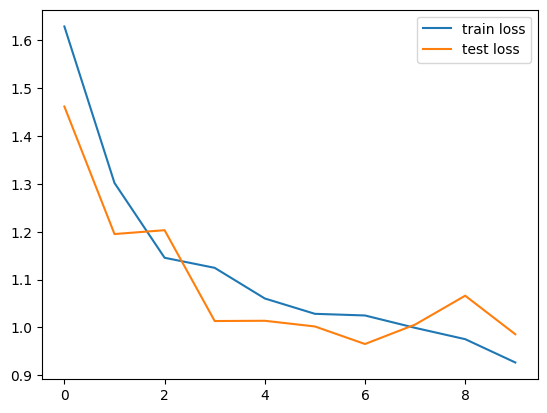

In [28]:
model2.to(device)

# treinar
train_losses, test_losses = fit(model2, criterion2, optimizer2, dataloaders_dict['train'], dataloaders_dict['val'], epochs=10)
plot_losses(train_losses, test_losses)

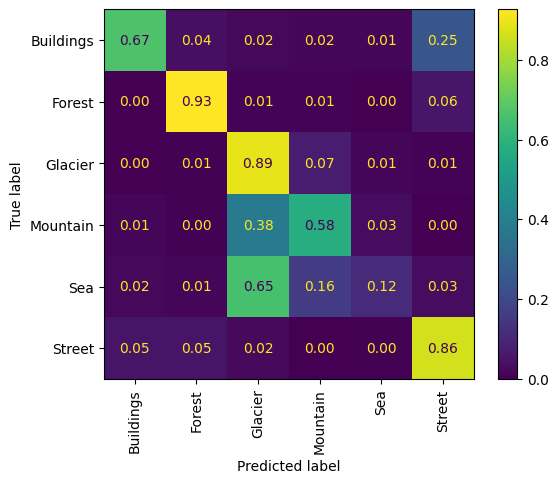

In [29]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model2, dataloaders_dict['test'])
matriz_confusao(true_labels, predicted, ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'])

## Questão 3: From scratch

In [30]:
# Carrega a CNN VGG11 e os pesos treinados com a base Imagenet
backbone3 = models.vgg11(weights=None)

# Remover a última camada totalmente conectada (classifier)
backbone3 = nn.Sequential(*list(backbone3.children())[:-1])

# Adicionar uma camada de flatten (conversão para vetor)
backbone3.add_module("flatten", nn.Flatten())

# Criar as camadas para classificação
classificador3 = MeuMLP(entrada=25088, camadas_escondidas=[256, 128, 64, 32] , saida=6 )

In [31]:
# instanciar a rede passando o backbone (nossa VGG16) e o classifier
model3 = FineTuningNetwork(backbone=backbone3, classifier=classificador3)

# loss and optimizer
criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model3.parameters())

# Congelar as camadas do backbone para não treinar novamente
set_parameter_requires_grad(backbone3, feature_extracting=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 Train Loss: 1.7087 Test Loss: 1.5558467933170477 Duracao: 0:01:13.104542
Epoch 2/10 Train Loss: 1.4991 Test Loss: 1.3950500654274243 Duracao: 0:01:13.470603
Epoch 3/10 Train Loss: 1.3330 Test Loss: 1.314623584137683 Duracao: 0:01:12.703965
Epoch 4/10 Train Loss: 1.3006 Test Loss: 1.255392653904749 Duracao: 0:01:11.845806
Epoch 5/10 Train Loss: 1.2404 Test Loss: 1.4083845949707887 Duracao: 0:01:11.926087
Epoch 6/10 Train Loss: 1.2089 Test Loss: 1.1870968879288077 Duracao: 0:01:12.165976
Epoch 7/10 Train Loss: 1.1982 Test Loss: 1.1613573126728378 Duracao: 0:01:12.193738
Epoch 8/10 Train Loss: 1.1973 Test Loss: 1.2305208065910558 Duracao: 0:01:11.950553
Epoch 9/10 Train Loss: 1.1018 Test Loss: 1.129872625454878 Duracao: 0:01:12.253111
Epoch 10/10 Train Loss: 1.0832 Test Loss: 1.1181896328713818 Duracao: 0:01:18.411233


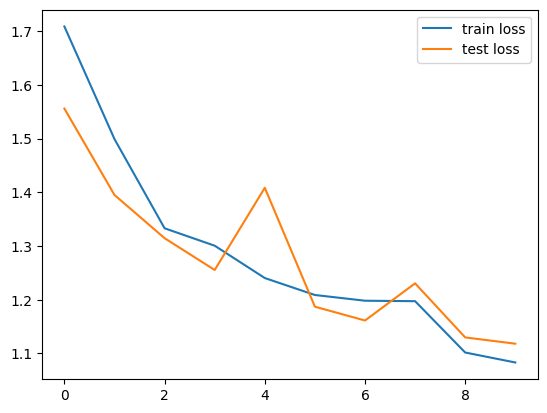

In [32]:
model3.to(device)

# treinar
train_losses, test_losses = fit(model3, criterion3, optimizer3, dataloaders_dict['train'], dataloaders_dict['val'], epochs=10)
plot_losses(train_losses, test_losses)

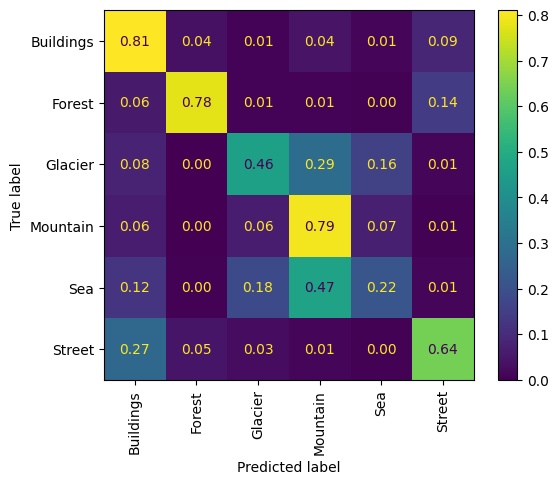

In [33]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model3, dataloaders_dict['test'])
matriz_confusao(true_labels, predicted, ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street'])